## Time Series Analysis

#### Seasonal Decomposition

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from dateutil.parser import parse

# Import Data
df = pd.read_csv('../data/time-series-seasonality/seasonal-data.csv', parse_dates=['Date'], index_col='Date')
df.reset_index(inplace=True)
df.head()

,Date,Temp-Final
0,2014-01-01 01:00:00,27.974586
1,2014-01-01 02:00:00,26.040642
2,2014-01-01 03:00:00,24.073209
3,2014-01-01 04:00:00,26.021572
4,2014-01-01 05:00:00,27.936445


<Axes: xlabel='Date'>

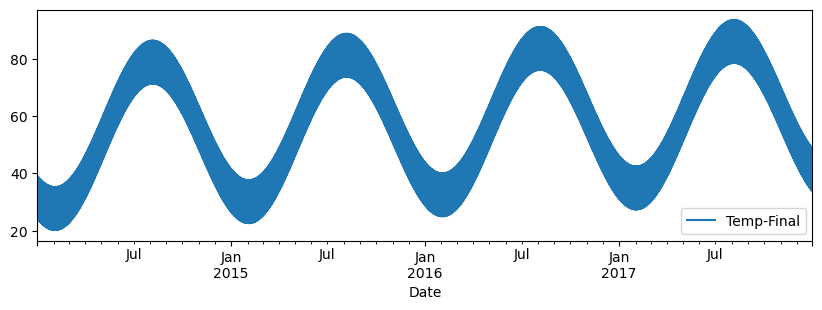

In [3]:
plt.rcParams.update({'figure.figsize': (10,3)})
df.plot()

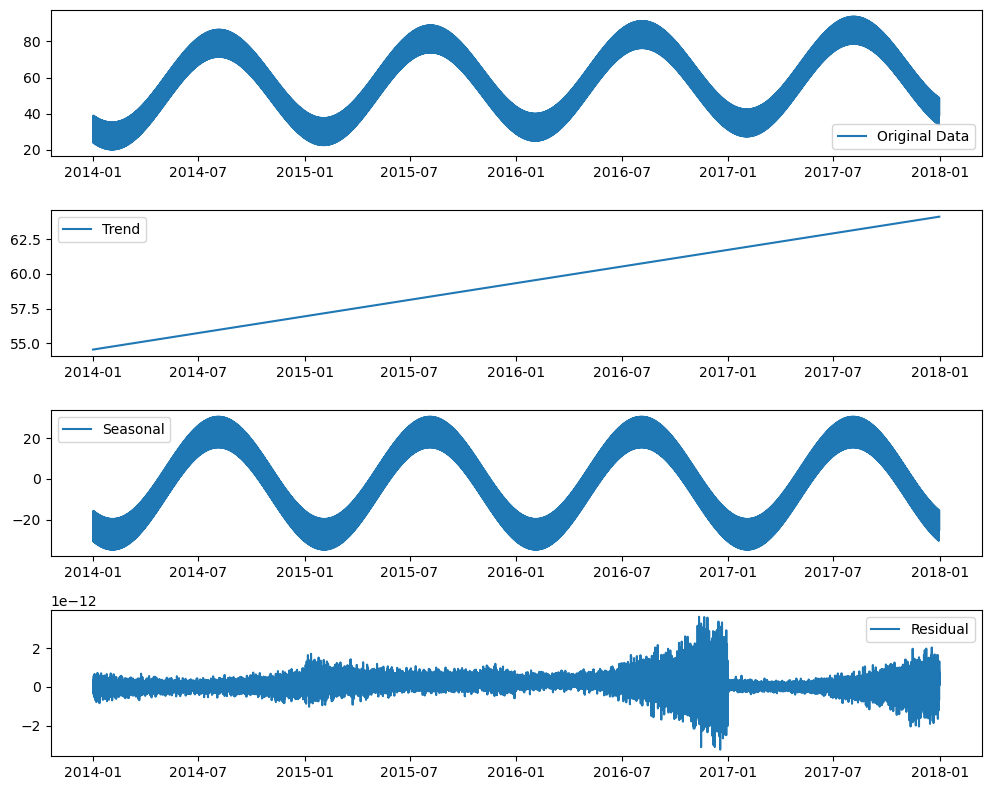

In [8]:
from statsmodels.tsa.seasonal import STL
stl = STL(df['Temp-Final'], period=8760)
result = stl.fit()

# Plot the decomposition components
plt.figure(figsize=(10, 8))
plt.subplot(4, 1, 1)
plt.plot(df['Date'], df['Temp-Final'], label='Original Data')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(df['Date'], result.trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(df['Date'], result.seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(df['Date'], result.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()

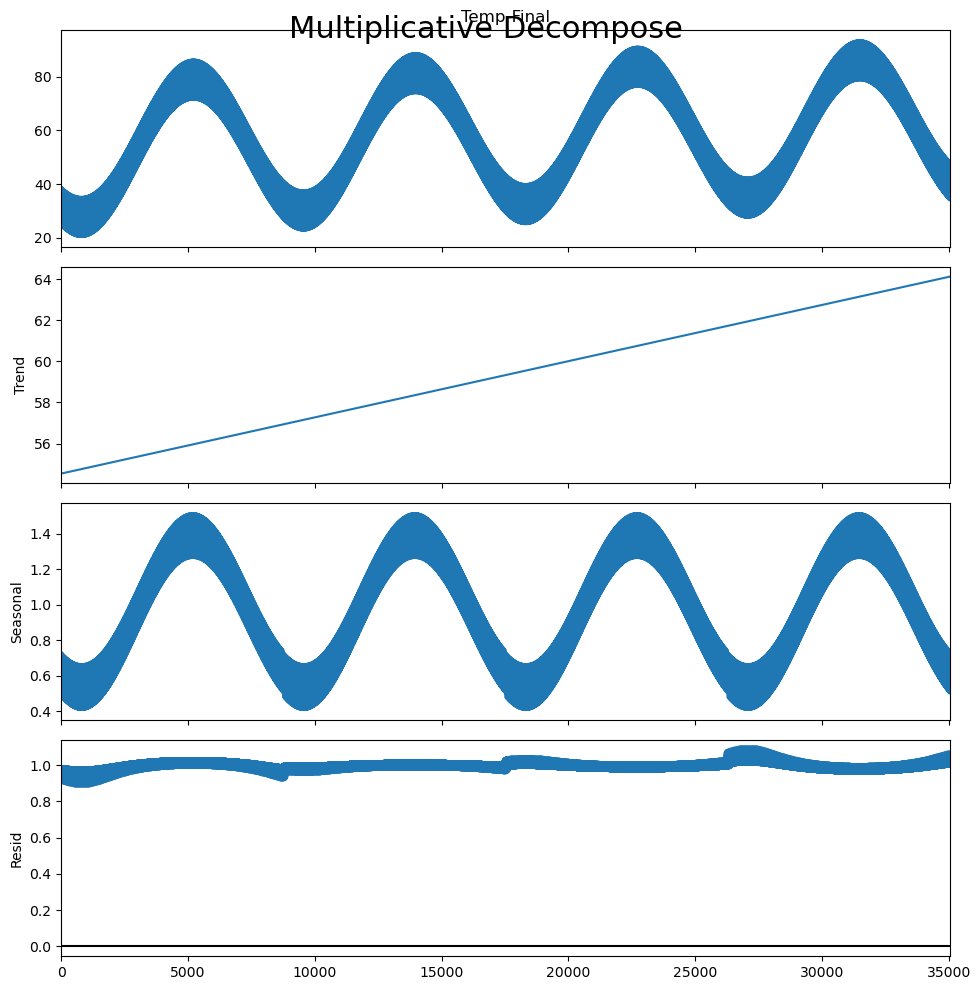

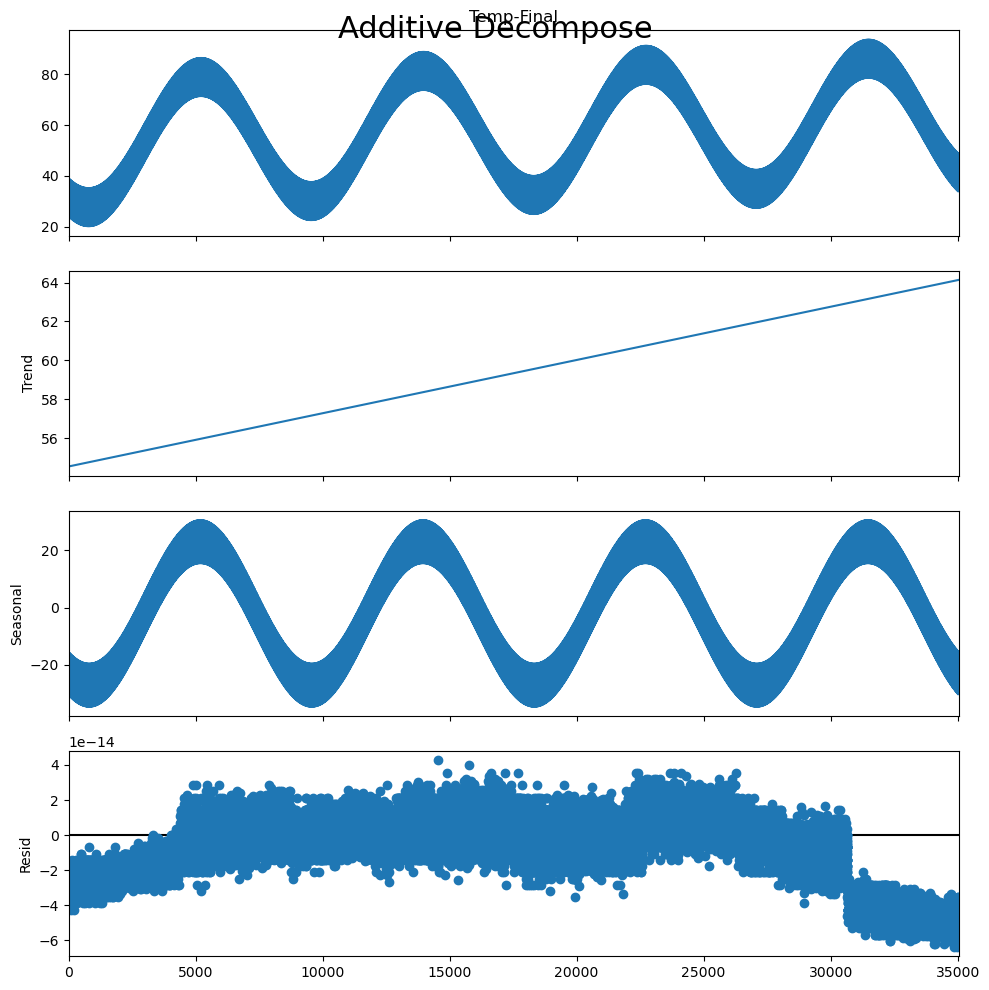

In [9]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(df['Temp-Final'], model='multiplicative', extrapolate_trend='freq', period=8760)

# Additive Decomposition
result_add = seasonal_decompose(df['Temp-Final'], model='additive', extrapolate_trend='freq', period=8760)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

In [ ]:
# Note:  The above does not recognize the cyclic (daily temperature) from the seasonal temperature.  
# This method is removing the daily cycle as if it is seasonal trend and leaving a seasonal trend when looking at year-over-year trends.

In [8]:
# Extract the Components ----
# Actual Values = Product of (Seasonal * Trend * Resid)
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seas,trend,resid,actual_values
Date,,,,
2014-01-01 01:00:00,0.894026,33.625484,0.930561,27.974586
2014-01-01 02:00:00,0.857953,33.616182,0.902901,26.040642
2014-01-01 03:00:00,0.821252,33.606879,0.872226,24.073209
2014-01-01 04:00:00,0.857956,33.597577,0.902736,26.021572
2014-01-01 05:00:00,0.894030,33.588274,0.930318,27.936445


<AxesSubplot:xlabel='Date'>

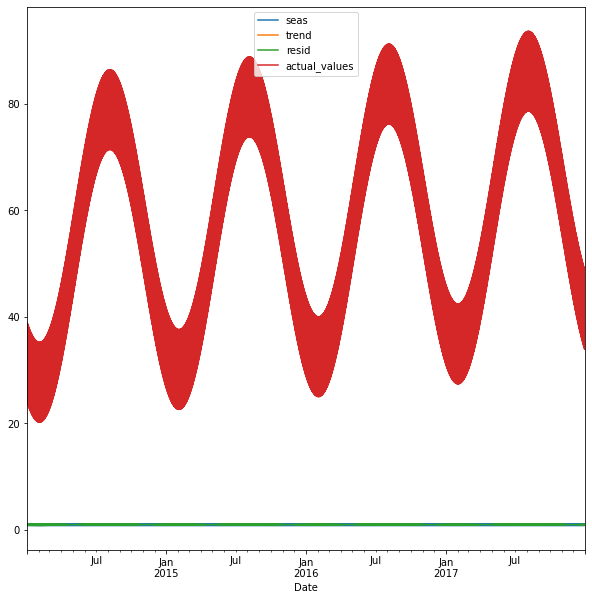

In [9]:
df_reconstructed.plot()

<AxesSubplot:xlabel='Date'>

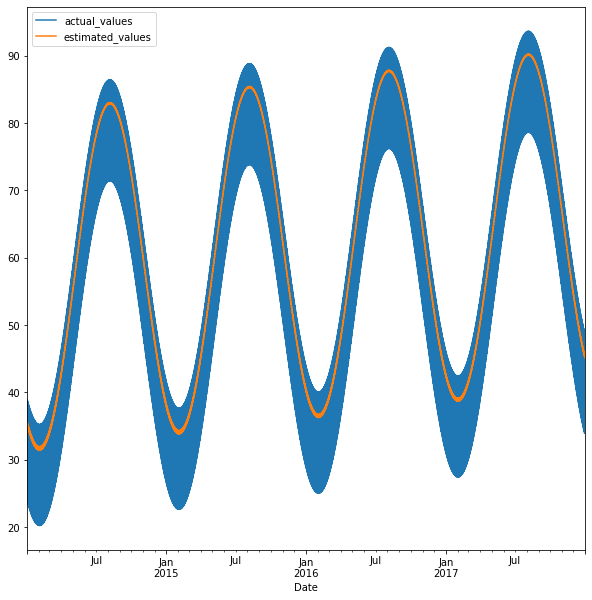

In [10]:
df_reconstructed['estimated_values'] = df_reconstructed['trend']+df_reconstructed['seas']+df_reconstructed['resid']
df_reconstructed[['actual_values', 'estimated_values']].plot()

In [14]:
df_reconstructed2 = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis=1)
df_reconstructed2.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed2.head()

,seas,trend,resid,actual_values
Date,,,,
2014-01-01 01:00:00,-5.653371,33.625484,0.002473,27.974586
2014-01-01 02:00:00,-7.577764,33.616182,0.002224,26.040642
2014-01-01 03:00:00,-9.535657,33.606879,0.001986,24.073209
2014-01-01 04:00:00,-7.577764,33.597577,0.001759,26.021572
2014-01-01 05:00:00,-5.653372,33.588274,0.001542,27.936445


<AxesSubplot:xlabel='Date'>

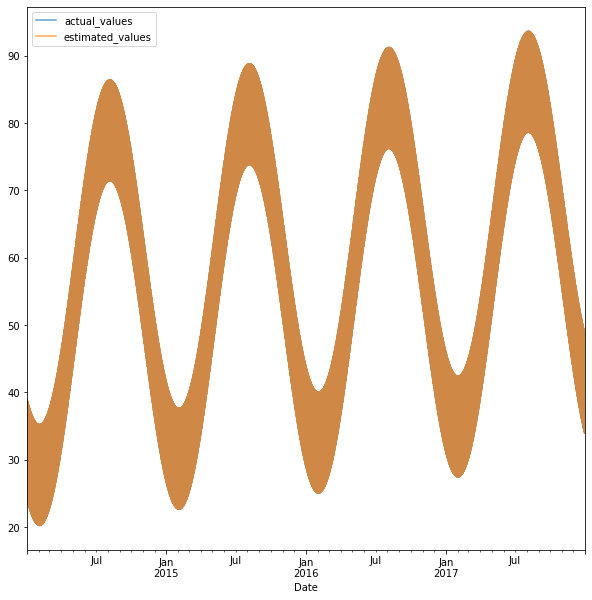

In [18]:
df_reconstructed2['estimated_values'] = df_reconstructed['trend']+df_reconstructed['seas']

df_reconstructed2[['actual_values', 'estimated_values']].plot(alpha=0.7)

In [19]:
df_reconstructed2[['actual_values', 'estimated_values']]

,actual_values,estimated_values
Date,,
2014-01-01 01:00:00,27.974586,27.972113
2014-01-01 02:00:00,26.040642,26.038418
2014-01-01 03:00:00,24.073209,24.071222
2014-01-01 04:00:00,26.021572,26.019813
2014-01-01 05:00:00,27.936445,27.934903
...,...,...
2017-12-30 20:00:00,45.640519,45.638794
2017-12-30 21:00:00,44.337216,44.335267
2017-12-30 22:00:00,42.852441,42.850257


<AxesSubplot:xlabel='Date'>

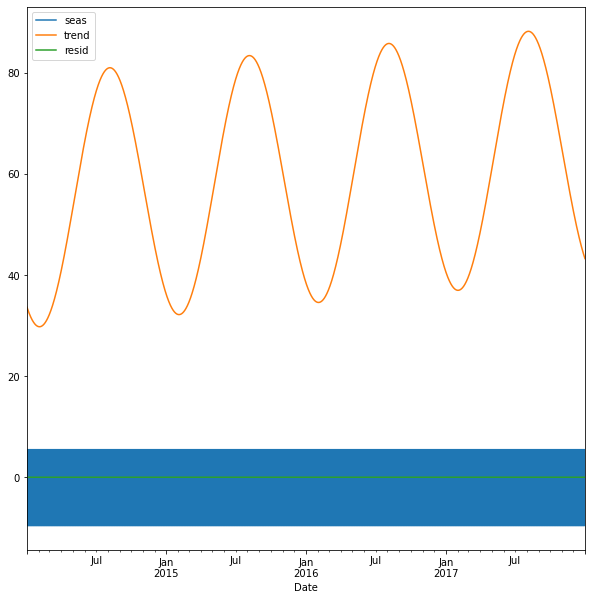

In [21]:
df_reconstructed2.iloc[:,0:3].plot()

In [24]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test
result = adfuller(df['Temp-Final'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(df['Temp-Final'].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

C:\Users\ejwda\Anaconda3\envs\PythonDataS2022\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\ejwda\Anaconda3\envs\PythonDataS2022\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


ADF Statistic: 0.0412628963415214
p-value: 0.9618143494278887
Critial Values:
   1%, -3.430536904252699
Critial Values:
   5%, -2.861622607060266
Critial Values:
   10%, -2.566813969142043

KPSS Statistic: 4.903142
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


C:\Users\ejwda\Anaconda3\envs\PythonDataS2022\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\ejwda\Anaconda3\envs\PythonDataS2022\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Temperature detrended by subtracting the least squares fit')

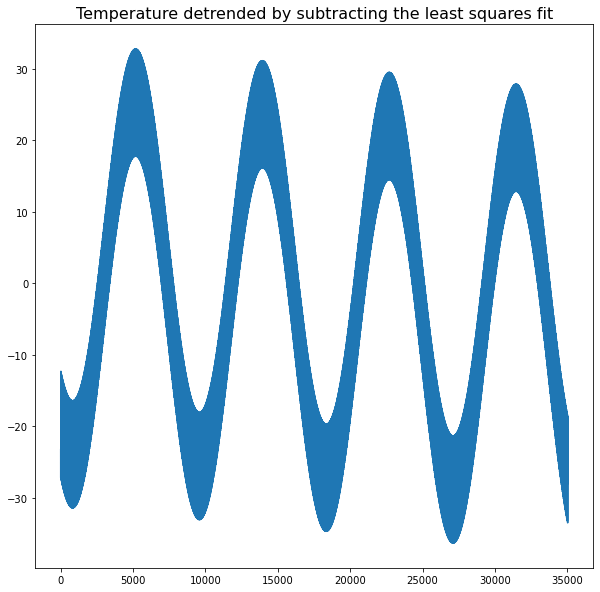

In [26]:
# Using scipy: Subtract the line of best fit
from scipy import signal

detrended = signal.detrend(df['Temp-Final'].values)
plt.plot(detrended)
plt.title('Temperature detrended by subtracting the least squares fit', fontsize=16)

In [ ]:
# Notice how the first and last parts of the sine wave may be influencing the detrending

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Temperature detrended by subtracting the trend component')

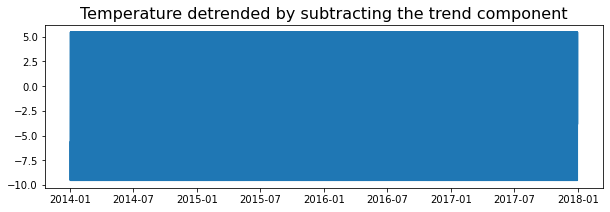

In [30]:
# Using statmodels: Subtracting the Trend Component.
from statsmodels.tsa.seasonal import seasonal_decompose

result_mul = seasonal_decompose(df['Temp-Final'], model='multiplicative', extrapolate_trend='freq')
detrended = df['Temp-Final'].values - result_mul.trend
plt.plot(detrended)
plt.title('Temperature detrended by subtracting the trend component', fontsize=16)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[]

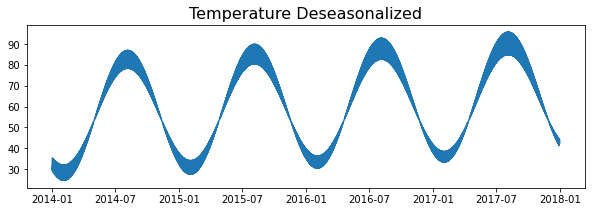

In [32]:
# Subtracting the Trend Component.

# Time Series Decomposition
result_mul = seasonal_decompose(df['Temp-Final'], model='multiplicative', extrapolate_trend='freq')

# Deseasonalize
deseasonalized = df['Temp-Final'].values / result_mul.seasonal

# Plot
plt.plot(deseasonalized)
plt.title('Temperature Deseasonalized', fontsize=16)
plt.plot()


<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

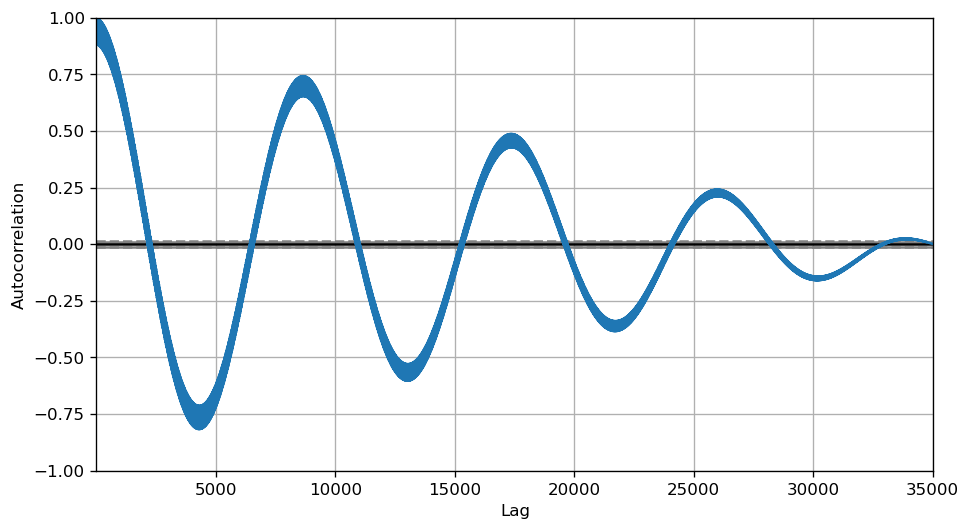

In [33]:
from pandas.plotting import autocorrelation_plot

# Draw Plot
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(df['Temp-Final'].tolist())

<IPython.core.display.Javascript object>

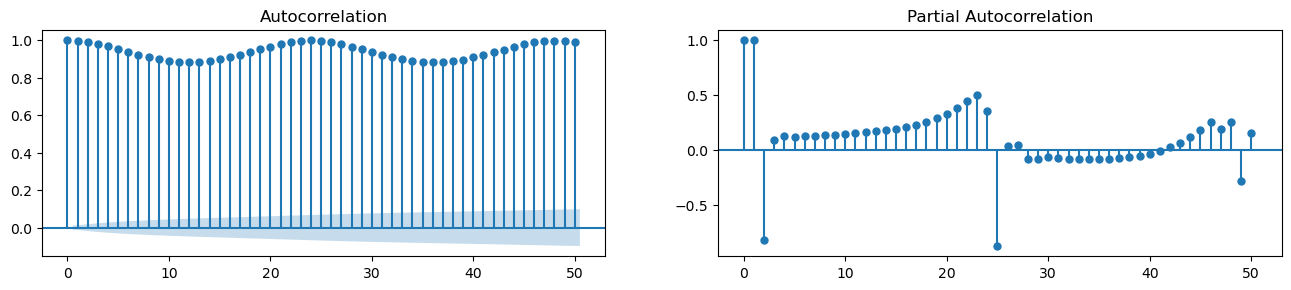

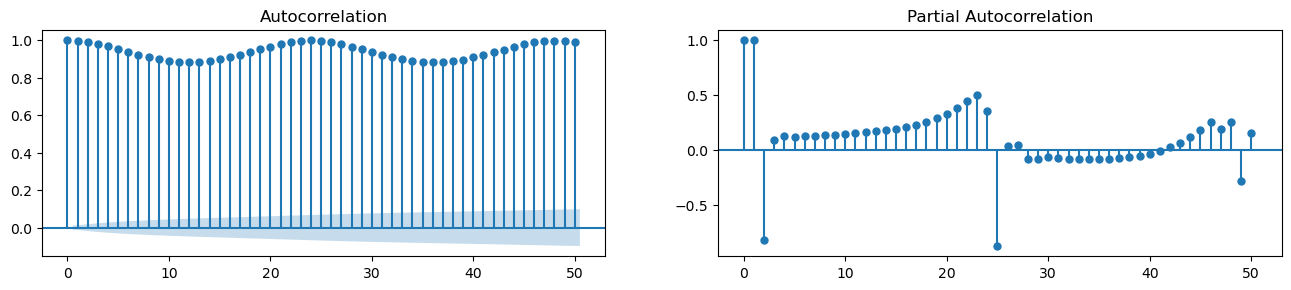

In [34]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Calculate ACF and PACF upto 50 lags
# acf_50 = acf(df.value, nlags=50)
# pacf_50 = pacf(df.value, nlags=50)

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df['Temp-Final'].tolist(), lags=50, ax=axes[0])
plot_pacf(df['Temp-Final'].tolist(), lags=50, ax=axes[1])

In [38]:
from statsmodels.tsa.arima_model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(df['Temp-Final'], order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

C:\Users\ejwda\Anaconda3\envs\PythonDataS2022\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\ejwda\Anaconda3\envs\PythonDataS2022\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information

AttributeError: 'pandas._libs.properties.CachedProperty' object has no attribute 'func'

In [ ]:
# 1,1,1 ARIMA Model
model = ARIMA(df['Temp-Final'], order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())